

# <center> Titanic </center>






### Group Number: 8
### Group members:
- Abdulrahman ALQannas
- Doaa Alsenani
- Ghida Qahtan
- Moayad Magadmi
---



## Introduction

- In this Kaggle competition, we aim to predict which passengers survived the Titanic shipwreck according to economic status (class), sex, age .

- In this competition, we face in binary classification problem and we try to solve this problem by using:-

     - Random Forest Classifier.	
     - KNeighbors Classifier.
     - Support Vector Classification.
     - Gaussian Process Classifier.
     - Decision Tree Classifier.
     - AdaBoost Classifier.
     - ExtraTreesClassifier 
     - Logistic Regression

- ### These datasets include 11 explanatory variables:

Train data have Survived (dependent variable) and other predictor variables.
Test data include the same variables that in train data, but without Survived (dependent variable) because this data will be submitted to kaggle.

-  #### Data Dictionary

|Feature|Dataset|Description|
|-------|---|---|
|Survival|Train|The number of survived the Titanic shipwreck| 
|Pclass|Train/Test|Economic status (class)| 
|Sex|Train/Test|male or female.| 
|Age|Train/Test|Age in years| 
|Sibsp/Parch|Train/Test|The number of siblings, spouses, or children aboard the Titanic.| 
|ticket|Train/Test|Ticket number.| 
|Fare|Train/Test|Passenger fare| 
|Cabin|Train/Test|Cabin number| 
|Embarked|Train/Test|Port of Embarkation| 



## Importing packages

In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.feature_selection import SelectFromModel

# To ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the Titanic

In [175]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
gender_submission = pd.read_csv('./datasets/gender_submission.csv') 

## Exploring the Data

In [176]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [177]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [178]:
train.info()
print('_'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

### Check Missing Values

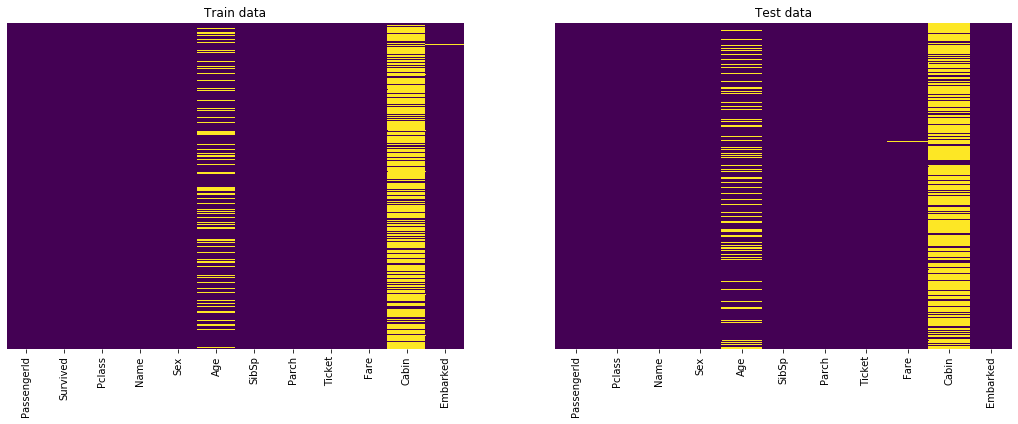

In [179]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
# Train data 
sns.heatmap(train.isnull(), yticklabels=False, ax = ax[0], cbar=False, cmap='viridis')
ax[0].set_title('Train data')
# Test data
sns.heatmap(test.isnull(), yticklabels=False, ax = ax[1], cbar=False, cmap='viridis')
ax[1].set_title('Test data');

In [180]:
#missing amount for train set
missing= train.isnull().sum().sort_values(ascending=False)
percentage = (train.isnull().sum()/ train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, percentage], axis=1, keys=['Missing', '%'])
missing_data.head(3)

,Missing,%
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


In [181]:
#missing amount for test set
missing= test.isnull().sum().sort_values(ascending=False)
percentage = (test.isnull().sum()/ test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, percentage], axis=1, keys=['Missing', '%'])
missing_data.head(3)

,Missing,%
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392


 #### Filling A Few Missing Values
 - #### Embarked Feature  in train dataset 

In [182]:
train.Embarked.fillna(value='S', inplace=True)

In [183]:
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

   - #### The Pclass of missing fare in test dataset

In [184]:
isn = pd.isnull(test['Fare'])
test[isn]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


- #### Filling missing Fare values in test dataset 

In [185]:
average_of_fare= test.groupby('Pclass')['Fare'].mean()
print('The mean fare for the Pclass (for missing fare data) is:',average_of_fare[3])

The mean fare for the Pclass (for missing fare data) is: 12.459677880184334


In [186]:
# filling the missing by mean
test.Fare.fillna(value=average_of_fare[3], inplace=True)

#### Let's see how to teat the Age column !

**The mean age of each Pclass in the train data.**

In [187]:
mean_age = train.groupby('Pclass')[['Age']].mean()
mean_age

,Age
Pclass,
1,38.233441
2,29.877630
3,25.140620


#### We fill the mean age with respect to each Pclass.

In [188]:
#defining a function 'impute_age'
def impute_age(age_pclass): # passing age_pclass as ['Age', 'Pclass']
    # Passing age_pclass[0] which is 'Age' to variable 'Age'
    Age = age_pclass[0]
    # Passing age_pclass[2] which is 'Pclass' to variable 'Pclass'
    Pclass = age_pclass[1]
    #applying condition based on the Age and filling the missing data respectively 
    if pd.isnull(Age):
        if Pclass == 1:
            return 38
        elif Pclass == 2:
            return 30
        else:
            return 25
    else:
        return Age

In [189]:
#train data
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)
#test data
test['Age'] = test[['Age','Pclass']].apply(impute_age,axis=1)

### Feature Engineering

 - ##### Cabin Feature

In [190]:
# train
train['Cabin']=train['Cabin'].notnull().astype('int')
train['Cabin'].unique()

array([0, 1])

In [191]:
# test
test['Cabin']=test['Cabin'].notnull().astype('int')
test['Cabin'].unique()

array([0, 1])

 - ##### Age Feature

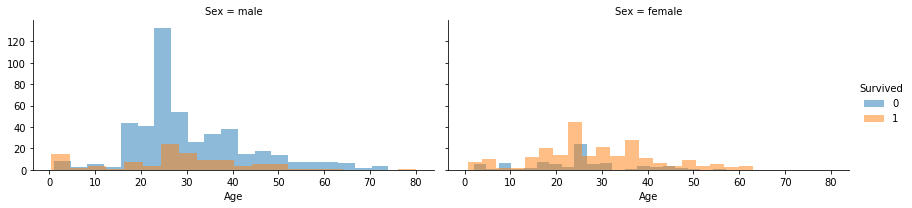

In [192]:
# Sex & Age
g = sns.FacetGrid(train, hue = 'Survived', col = 'Sex', height = 3, aspect = 2)
g.map(plt.hist, 'Age', alpha = .5, bins = 20)
g.add_legend()
plt.show()

- The graph shows that the death rate of males was higher than females
- The graph shows that older passengers had less chance of survival.

In [193]:
#Change the data types
train['Age'] = train['Age'].astype(int)
test['Age'] = test['Age'].astype(int)

In [194]:
def age_range(df):
    df['Age'].loc[df['Age'] <= 16 ] = 0
    df['Age'].loc[(df['Age'] > 16) & (df['Age'] <= 32)] = 1
    df['Age'].loc[(df['Age'] > 32) & (df['Age'] <= 48)] = 2
    df['Age'].loc[(df['Age'] > 48) & (df['Age'] <= 64)] = 3
    df['Age'].loc[df['Age'] > 64] = 4   
age_range(train)
age_range(test)

### Making several new features 

- ####  Title Feature

In [195]:
# Creating title dictionary in train data
titles = set()
for name in train['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}
train['Title'] = train['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())  
# Mapping Titles
train['Title'] = train.Title.map(Title_Dictionary)

In [196]:
# Creating Title dictionary in test data
titles = set()
for name in test['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())
Title_Dictionary_test = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}
test['Title'] = test['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())    
# Mapping Titles
test['Title'] = test.Title.map(Title_Dictionary_test)

In [197]:
# Missing values
test[test['Title'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,2,0,0,PC 17758,108.9,1,C,NaN


In [198]:
# Filling missing values in title
test['Title'].fillna(value='Mr', inplace=True)

- #### Family Size Features

In [199]:
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

#### No more missing data

In [200]:
train['FamilySize'] = train['FamilySize'].astype(int)
test['FamilySize'] = test['FamilySize'].astype(int)
def family_range(df):
    df['FamilySize'].loc[df['FamilySize'] <= 1 ] = 0
    df['FamilySize'].loc[(df['FamilySize'] >= 2) & (df['FamilySize'] <= 4)] = 1
    df['FamilySize'].loc[df['FamilySize'] >= 5] = 2   
family_range(train)
family_range(test)

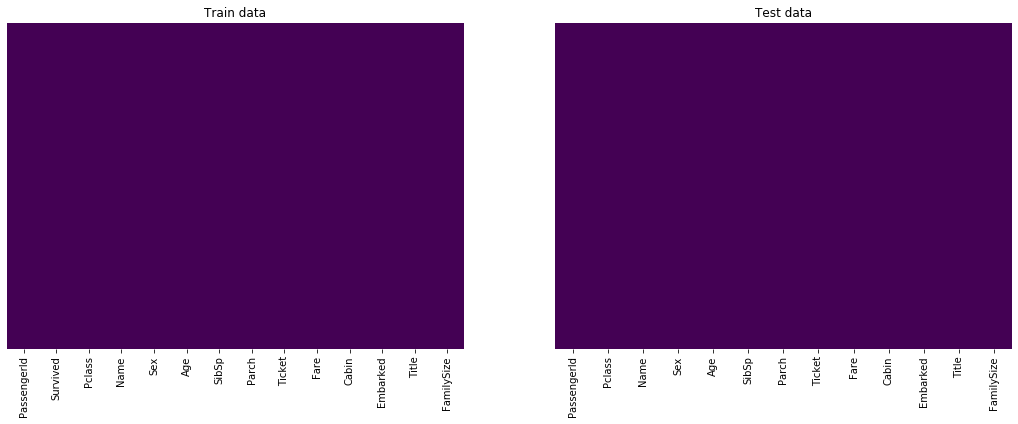

In [201]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
# Train data 
sns.heatmap(train.isnull(), yticklabels=False, ax = ax[0], cbar=False, cmap='viridis')
ax[0].set_title('Train data')
# Test data
sns.heatmap(test.isnull(), yticklabels=False, ax = ax[1], cbar=False, cmap='viridis')
ax[1].set_title('Test data');

### Dummies
##### Creating Dummies For Categorical Columns.

In [202]:
# Train Data
train = pd.get_dummies(train, columns=['Sex','Embarked','Title'],drop_first=True)

In [203]:
# Test Data
test= pd.get_dummies(test, columns=['Sex','Embarked','Title'],drop_first=True)
test['Title_Royalty'] = 0    # adding Title_Royalty column to match columns in the train df

### Analyze by visualizing data

- #### Survived Correlation Matrix 

Now let's take a look at the most important variables, which will have strong linear releationship with 
<b>Survived</b> variable .<br><br>

<function matplotlib.pyplot.show(*args, **kw)>

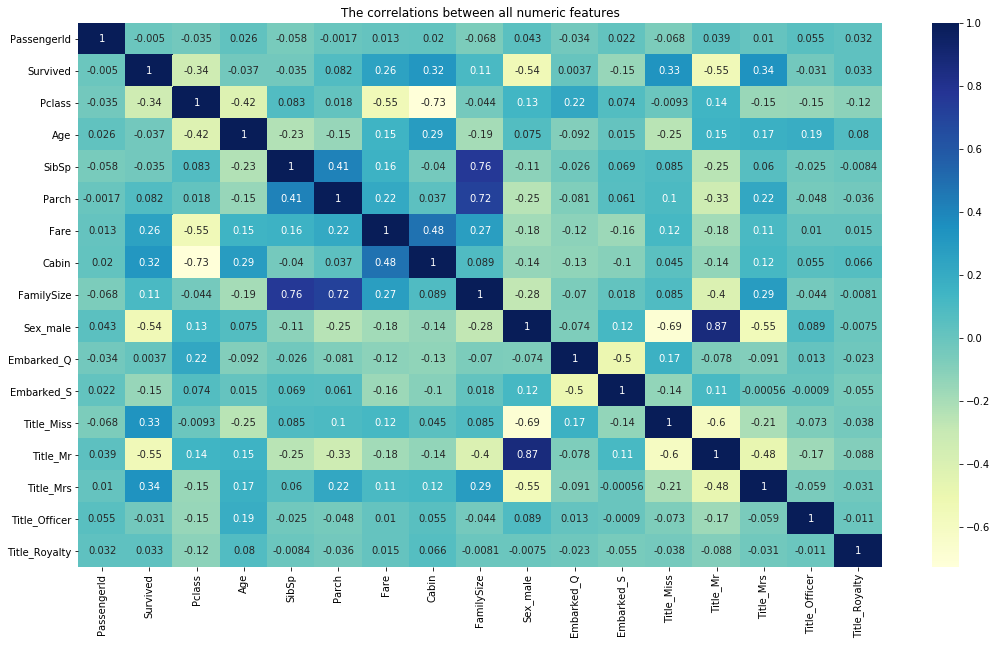

In [204]:
fig=plt.figure(figsize=(18,10))
ax = fig.gca()
sns.heatmap(train.corr(), annot=True,ax=ax, cmap=plt.cm.YlGnBu)
ax.set_title('The correlations between all numeric features')
palette =sns.diverging_palette(80, 110, n=146)
plt.show

In [205]:
# correlation with the target
corr_matrix = train.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived         1.000000
Title_Mrs        0.344935
Title_Miss       0.332795
Cabin            0.316912
Fare             0.257307
FamilySize       0.108631
Parch            0.081629
Title_Royalty    0.033391
Embarked_Q       0.003650
PassengerId     -0.005007
Title_Officer   -0.031316
SibSp           -0.035322
Age             -0.037059
Embarked_S      -0.149683
Pclass          -0.338481
Sex_male        -0.543351
Title_Mr        -0.549199
Name: Survived, dtype: float64

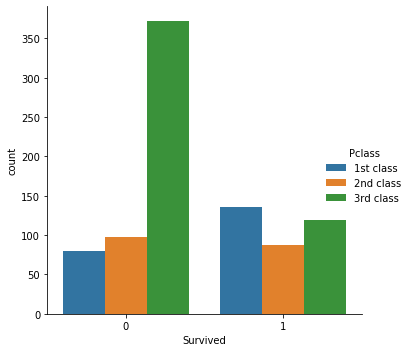

In [206]:
g = sns.factorplot('Survived',data=train,kind='count',hue='Pclass')
g._legend.set_title('Pclass')
# replace labels
new_labels = ['1st class', '2nd class', '3rd class']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

- The graph shows that the survival rate in the  3rd class was lowest than the 1st and 2nd class.

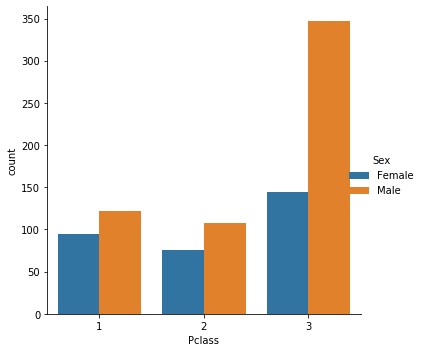

In [207]:
g = sns.factorplot('Pclass',data=train,hue='Sex_male',kind='count')
g._legend.set_title('Sex')
# replace labels
new_labels = ['Female', 'Male']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

- The graph shows that the reason for the high death rate of men than women because most of them were in the 3rd class.  

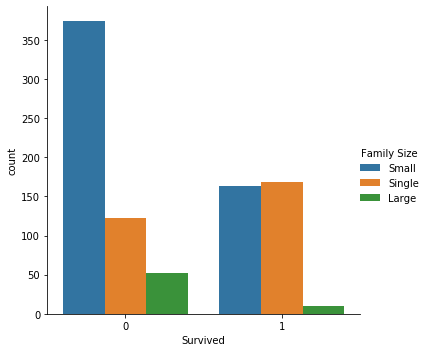

In [208]:
g = sns.factorplot('Survived',data=train,kind='count',hue='FamilySize')
g._legend.set_title('Family Size')
# replace labels
new_labels = ['Small', 'Single', 'Large']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

- The graph shows that the number of deaths in singles was more than the families due to the plan followed in the rescue, which depends on the rescue of families first and then singles. 

### Modeling 

#### Model Prep: Create X  and y variables

- #### Dropping Some Columns

In [209]:
# Train data
features_drop = ['PassengerId','Name', 'Ticket', 'Survived','SibSp','Parch']

In [210]:
selected_features = [x for x in train.columns if x not in features_drop]

In [211]:
# Test data
features_drop_test = ['PassengerId','Name', 'Ticket','SibSp','Parch']

In [212]:
selected_features_test = [x for x in test.columns if x not in features_drop_test]

- #### Now, separate the selected column in X_train and Survived in y_train

In [213]:
# Train data
X = train[selected_features]
y = train['Survived']

In [214]:
# Test data
testing = test[selected_features_test]

- #### Splitting and Standardizing Train Data to Obtain Test Scores

In [215]:
ss = StandardScaler()
Xs =ss.fit_transform(X)

In [216]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3,random_state=55, stratify=y) 

### 1- Build Decision Tree Classifier Model

In [217]:
tree= DecisionTreeClassifier()
tree.fit(X_train, y_train)
print('test score' , tree.score(X_train, y_train))
print('test score' , tree.score(X_test, y_test))

test score 0.9470304975922953
test score 0.8134328358208955


In [218]:
y_pred =tree.predict(testing)

 - #### Fit a BaggingClassifier with a decision tree base estimator

In [219]:
dt = DecisionTreeClassifier()
dt_en = BaggingClassifier(base_estimator=dt, n_estimators=100, max_features=10)
dt_en.fit(X_train, y_train)
print('test score' , dt_en.score(X_train, y_train))
print('test score' , dt_en.score(X_test, y_test))

test score 0.942215088282504
test score 0.8246268656716418


In [220]:
y_pred = dt_en.predict(testing) 

- #### Grid Search for Bagging Classifiers

In [221]:
param = { 'max_features': [0.3, 0.6, 1],
        'n_estimators': [50, 150, 200], 
         'base_estimator__max_depth': [3, 5, 20]}

In [222]:
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), oob_score=True)
model_gs = GridSearchCV(model,param, cv=6, verbose=1, n_jobs=-1 )
model_gs.fit(X_train, y_train)

Fitting 6 folds for each of 27 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   12.2s finished


GridSearchCV(cv=6, error_score=nan,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                               class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=None,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                         

In [223]:
model_gs.best_params_

{'base_estimator__max_depth': 20, 'max_features': 0.6, 'n_estimators': 50}

In [224]:
model_gs.best_estimator_.oob_score_

0.8234349919743178

### 2 - Build Random Forest Classifier Model

In [225]:
randomF = RandomForestClassifier(max_depth=350, n_estimators=9, max_features=11, random_state=14, min_samples_split=3)
randomF.fit(X_train, y_train)
print('Train score :',randomF.score(X_train, y_train))
print('Ttest score :',randomF.score(X_test, y_test))

Train score : 0.9245585874799358
Ttest score : 0.832089552238806


In [226]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(randomF, X, y, cv=cv).mean()

0.8215805661917017

In [227]:
y_pred=randomF.predict(testing)

### 3- Build Extra Trees Classifier Model

In [228]:
et = ExtraTreesClassifier(n_estimators=66, min_samples_split=7)
et.fit(X_train, y_train)
print('Train score :',et.score(X_train, y_train))
print('Ttest score :',et.score(X_test, y_test))

Train score : 0.9052969502407705
Ttest score : 0.8208955223880597


In [229]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(et, X, y, cv=cv).mean()

0.8283346933651371

In [230]:
y_pred =et.predict(testing)

### 4 - Build KNeighbors Classifier	Model

In [231]:
knn_classifier = KNeighborsClassifier(n_neighbors=7, leaf_size=48, weights='uniform',p=1)  
knn_classifier.fit(X_train, y_train)
print(knn_classifier.score(X_train, y_train))
print (knn_classifier.score(X_test, y_test))

0.8330658105939005
0.8097014925373134


In [232]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(knn_classifier, X, y, cv=cv).mean()

0.796899127487289

In [233]:
y_pred = knn_classifier.predict(testing) 

- #### Fit a BaggingClassifier with a Knn base estimator

In [234]:
knn = KNeighborsClassifier()
knn_en = BaggingClassifier(base_estimator=knn, n_estimators=45, oob_score=True, max_features=9, random_state=99)
knn_en.fit(X_train, y_train)

print(knn_en.score(X_train, y_train))
print(knn_en.score(X_test, y_test))

0.8796147672552167
0.8208955223880597


In [235]:
y_pred = knn_en.predict(testing) 

In [236]:
knn_en.estimators_[12]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

### 5 - Build SVM Model

- #### SVM with Linear

In [237]:
svm_l = svm.SVC(kernel='linear', C=33)
svm_l.fit(X_train, y_train)
print('Train : ', svm_l.score(X_train, y_train))
print('Test: ', svm_l.score(X_test, y_test))

Train :  0.8234349919743178
Test:  0.8544776119402985


In [238]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(svm_l, Xs, y, cv=cv).mean()

0.8316740945326722

In [239]:
cross_val_score(randomF, X, y, cv=cv)

array([0.79329609, 0.80898876, 0.83146067, 0.82022472, 0.85393258])

In [240]:
y_pred = svm_l.predict(testing) 

- #### SVM with Poly

In [241]:
svm_p = svm.SVC(kernel='poly', C=3)
svm_p.fit(X_train, y_train)
print(svm_p.score(X_train, y_train))
print(svm_p.score(X_test, y_test))

0.6452648475120385
0.664179104477612


In [242]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(svm_p, Xs, y, cv=cv).mean()

0.8283346933651371

In [243]:
y_pred = svm_p.predict(testing) 

- #### SVM with Rbf

In [244]:
svm_rbf = svm.SVC(kernel='rbf', C=4)
svm_rbf.fit(X_train, y_train)
print(svm_rbf.score(X_train, y_train))
print(svm_rbf.score(X_test, y_test))

0.6773675762439807
0.6716417910447762


In [245]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(svm_rbf, Xs, y, cv=cv).mean()

0.833952670893227

In [246]:
y_pred = svm_rbf.predict(testing) 

### 6- Build Logistic Regression Model


In [247]:
logreg = LogisticRegression(max_iter=300)
logreg.fit(X_train, y_train)
print('train score' , logreg.score(X_train, y_train))
print('test score' , logreg.score(X_test, y_test))

train score 0.8154093097913323
test score 0.8619402985074627


In [248]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(logreg, X, y, cv=cv).mean()

0.8238026489234824

In [249]:
cross_val_score(randomF, X, y, cv=cv)

array([0.79329609, 0.80898876, 0.83146067, 0.82022472, 0.85393258])

In [250]:
y_pred = logreg.predict(testing) 

### 7- Build AdaBoost Classifier Model

In [251]:
adaboost = AdaBoostClassifier(n_estimators=67)
adaboost.fit(X_train, y_train)
print('Train accuracy:', adaboost.score(X_train, y_train))
print('Test accuracy:',adaboost.score(X_test, y_test))

Train accuracy: 0.8378812199036918
Test accuracy: 0.8246268656716418


In [252]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(adaboost, X, y, cv=cv).mean()

0.8069801016885318

In [253]:
y_pred = adaboost.predict(testing) 

### Submission

In [254]:
thesubmission = gender_submission.copy()
thesubmission['Survived'] = y_pred
thesubmission['Survived'].head()
thesubmission.to_csv('thesubmission.csv', index=False)

##  Results

In [255]:
list_of_Scores = list()

In [256]:
# Decision Tree Classifier
results = {'Model':'Decision Tree Classifier',
           'Train Score':tree.score(X_train, y_train),
           'Test Score':tree.score(X_test, y_test),
           'Kaggle Score':None}
list_of_Scores.append(results)

# Bagging Classifier with Decision Tree 
results = {'Model':'Bagging with Decision Tree ',
           'Train Score':dt_en.score(X_train, y_train),
           'Test Score':dt_en.score(X_test, y_test),
           'Kaggle Score':0.75598}
list_of_Scores.append(results)

# Random Forest Classifier
results = {'Model':'Random Forest Classifier',
           'Train Score': randomF.score(X_train, y_train),
           'Test Score':randomF.score(X_test, y_test),
           'Kaggle Score':0.77990
}
list_of_Scores.append(results)

# Extra Trees Classifier
results = {'Model':'Extra Trees Classifier',
           'Train Score':et.score(X_train, y_train),
           'Test Score': et.score(X_test, y_test),
           'Kaggle Score':None}
list_of_Scores.append(results)

# KNeighbors Classifier
results = {'Model':'KNeighbors Classifier',
           'Train Score':knn_classifier.score(X_train, y_train),
           'Test Score':knn_classifier.score(X_test, y_test),
           'Kaggle Score':0.77511}
list_of_Scores.append(results)

# Bagging Classifier with a Knn 
results = {'Model':'Bagging Classifier with Knn ',
           'Train Score': knn_en.score(X_train, y_train),
           'Test Score':knn_en.score(X_test, y_test),
           'Kaggle Score':0.66507}
list_of_Scores.append(results)

# SVM with Linear
results = {'Model':'SVM with Linear',
           'Train Score': svm_l.score(X_train, y_train),
           'Test Score':svm_l.score(X_test, y_test),
           'Kaggle Score':0.80382}
list_of_Scores.append(results)


# SVM with Poly
results = {'Model':'SVM with Poly',
           'Train Score':svm_p.score(X_train, y_train),
           'Test Score':svm_p.score(X_test, y_test),
           'Kaggle Score':None}
list_of_Scores.append(results)

# SVM with Rbf 
results = {'Model':"SVM with Rbf",
           'Train Score':svm_rbf.score(X_train, y_train),
           'Test Score':svm_rbf.score(X_test, y_test),
           'Kaggle Score':None}
list_of_Scores.append(results) 


# Logistic Regression
results = {'Model':'Logistic Regression',
           'Train Score':logreg.score(X_train, y_train),
           'Test Score':logreg.score(X_test, y_test),
           'Kaggle Score':0.80382}
list_of_Scores.append(results)

# AdaBoost Classifier
results = {'Model':'AdaBoost Classifier ',
           'Train Score':adaboost.score(X_train, y_train),
           'Test Score':adaboost.score(X_test, y_test),
           'Kaggle Score':0.77511}
list_of_Scores.append(results)

In [257]:
df_results = pd.DataFrame(list_of_Scores)

- #### This table provides all the scores that we got from each model.

In [258]:
df_results

,Model,Train Score,Test Score,Kaggle Score
0,Decision Tree Classifier,0.947030,0.813433,NaN
1,Bagging with Decision Tree,0.942215,0.824627,0.75598
2,Random Forest Classifier,0.924559,0.832090,0.77990
3,Extra Trees Classifier,0.905297,0.820896,NaN
4,KNeighbors Classifier,0.833066,0.809701,0.77511
5,Bagging Classifier with Knn,0.879615,0.820896,0.66507
6,SVM with Linear,0.823435,0.854478,0.80382
7,SVM with Poly,0.645265,0.664179,NaN
8,SVM with Rbf,0.677368,0.671642,NaN
9,Logistic Regression,0.815409,0.861940,0.80382


# Evaluation

In this modeling we use cross-validation to evaluate the results after data cleaning. According to the Logistic Regression and SVM important featrues, we inference those featrues can play a major part in prediction. The most important featrues are: Fare,Title_Mr and they gave us a good predect of Survived feature. According to the two models's important featrues, we inference those featrues can play a major part in prediction. As we got these result:

Logistic Regression resulte:

        Train Score: 0.8154093097913323
        Test  Score: 0.8619402985074627

SVM resulte:

        Train Score: 0.8234349919743178
        Test  Score: 0.8544776119402985

And when we tested the Corss Validation of Logestic, the results were:

Logistic Regression resulte:

        "[0.79329609, 0.80898876, 0.83146067, 0.82022472, 0.85393258]"

SVM resulte:

        "[0.79329609, 0.80898876, 0.83146067, 0.82022472, 0.85393258]"
        
        
With an average of: "0.8215805661917017" ~ 0.82 of Logistic Regression and "0.8316740945326722" ~ 0.83 of SVM this is a good ratio, as it means that the model can generalize any new data that can enter the model at 82-83 percent of accuracy, as this result indicates that the model is right fit because a low  viariance of it.

In the picture below the first three points score we get in this  modling in kaggle which it show the same public score for the two model a Logistic Regression and SVM.

### Kaggle Score

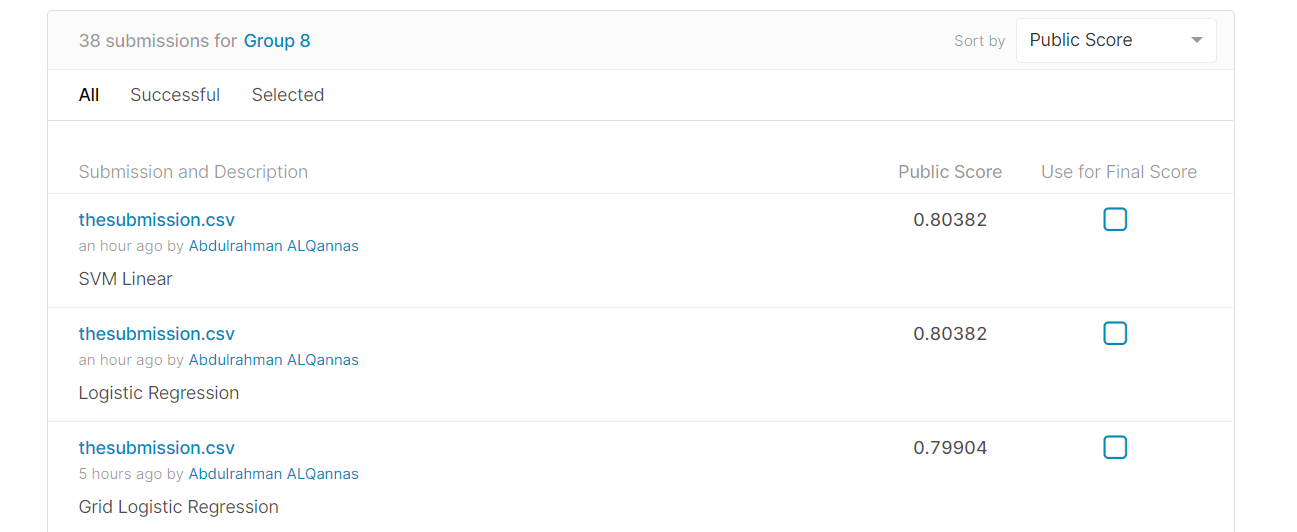